In [2]:
#线性回归实现
%matplotlib inline
import torch
from IPython import display
from matplotlib import pyplot as plt
import numpy as np
import random

In [2]:
#训练数据集样本数为1000，输入个数（特征数）为2
num_inputs = 2
num_examples = 1000
#W,b
true_weight = torch.tensor([2,-3.4])
true_b = torch.tensor(4.2)
#y=Xw+b+ϵ
features = torch.randn(num_examples,num_inputs,dtype=torch.float32)
labels = features @ true_weight + true_b
noise = torch.tensor(np.random.normal(0,0.01,size=labels.size()))
labels += noise
print(features[0],labels[0])

tensor([-1.6734, -0.1076]) tensor(1.2136)


torch.Size([1000])


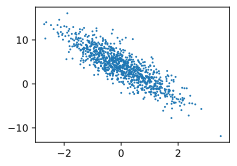

In [3]:
#线性关系观察
def use_svg_display():
    # 用矢量图显示
    display.set_matplotlib_formats('svg')
def set_figsize(figsize=(3.5, 2.5)):
    use_svg_display()
    # 设置图的尺寸
    plt.rcParams['figure.figsize'] = figsize

set_figsize()
print(labels.size())
#第二个特征和labels之间的线性关系
plt.scatter(features[:, 1].numpy(), labels.numpy(), 1);


In [4]:
#batch
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)  # 样本的读取顺序是随机的
    for i in range(0, num_examples, batch_size):
        j = torch.LongTensor(indices[i: min(i + batch_size, num_examples)]) # 最后一次可能不足一个batch
        yield  features.index_select(0, j), labels.index_select(0, j)
batch_size = 10
for X,y in  data_iter(batch_size,features,labels):
    print(X,y)
    break

tensor([[ 0.3008,  0.2771],
        [-0.8166, -0.5068],
        [-2.0901, -0.4891],
        [-1.5501,  1.1696],
        [ 0.1389, -0.2788],
        [ 0.6766, -1.3490],
        [ 0.7665, -0.0291],
        [-0.8162, -1.2485],
        [-0.3891,  1.3514],
        [ 0.2531,  0.2340]]) tensor([ 3.8581,  4.2886,  1.6871, -2.8700,  5.4352, 10.1351,  5.8287,  6.8128,
        -1.1734,  3.9071])


In [10]:
#初始化模型参数
#均值为0、标准差为0.01的正态随机数，偏差则初始化成0
w = torch.tensor(np.random.normal(0, 0.01, (num_inputs, 1)), dtype=torch.float32)
b = torch.zeros(1, dtype=torch.float32)
#需要对这些参数求梯度来迭代参数的值
w.requires_grad_(requires_grad=True)
b.requires_grad_(requires_grad=True) 
#定义模型
def linreg(X, w, b):  # 本函数已保存在d2lzh_pytorch包中方便以后使用
    return torch.mm(X, w) + b
#定义损失函数
#pytorh里面MSEloss没有除以2的操作
def squared_loss(y_hat,y):
    return (y_hat-y.view(y_hat.size()))**2 / 2
#定义优化算法
def sgd(params,lr,batch_size):
    for param in params:
        param.data -= lr * param.grad/batch_size
#训练模型
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss
for epoch in range(num_epochs):
    # 在每一个迭代周期中，会使用训练数据集中所有样本一次（假设样本数能够被批量大小整除）。X
    # 和y分别是小批量样本的特征和标签
    for X,y in data_iter(batch_size,features,labels):
        l = loss(net(X,w,b),y).sum() #l是小批量中的loss
        l.backward()
        sgd([w,b],lr,batch_size)#参数更新
        #一个batch结束要梯度清零
        w.grad.data.zero_()
        b.grad.data.zero_()
    train_l = loss(net(features,w,b),labels) #再将整个数据传入调好参数的网络中
    print('epoch %d, loss %f' % ((epoch+1),train_l.mean()))
print(w,b)
print(true_weight,true_b)

epoch 1, loss 0.050706
epoch 2, loss 0.000220
epoch 3, loss 0.000054
tensor([[ 1.9998],
        [-3.3993]], requires_grad=True) tensor([4.1985], requires_grad=True)
tensor([ 2.0000, -3.4000]) tensor(4.2000)


In [3]:
#线性回归简洁实现
#生成数据集
num_input = 2
num_examples = 1000
true_weight = torch.tensor([2,-3.4])
true_b = torch.tensor(4.2)
features = torch.tensor(np.random.normal(0,1,(num_examples,num_input)),dtype=torch.float)
labels = features @ true_weight + true_b
labels += torch.tensor(np.random.normal(0,0.01,size=labels.size()),dtype=torch.float)

#数据读取，PyTorch提供了data包来读取数据。由于data常用作变量名，我们将导入的data模块用Data代替。
import torch.utils.data as Data
batch_size = 10
# 将训练数据的特征和标签组合
dataset = Data.TensorDataset(features, labels)
#随机读取小批量, shuffle=True 样本的读取顺序是随机的
data_iter = Data.DataLoader(dataset,batch_size,shuffle=True)
for X,y in data_iter:
    print(X,y)
    break              

tensor([[ 0.1864, -0.0855],
        [-0.5188, -0.7406],
        [ 0.5342, -0.3638],
        [ 0.2379,  0.2753],
        [-0.5702, -0.3767],
        [ 0.3805,  0.7302],
        [-0.4202, -0.0146],
        [-0.1083,  0.8350],
        [-0.7129,  0.2008],
        [ 0.5745, -1.3320]]) tensor([4.8678, 5.6784, 6.5018, 3.7326, 4.3243, 2.4868, 3.3960, 1.1344, 2.0873,
        9.8820])


In [4]:
#定义模型
#pytorch模型定义是利用torch.nn模块中Module数据结构——
#表示神经网络中的某个层（layer），也可以表示一个包含很多层的神经网络，常见用法就是继承nn.Module
#实例包含初始化和前向传播
import torch.nn as nn
class LinearNet(nn.Module):
    def __init__(self, n_feature):
        super(LinearNet, self).__init__()
        self.linear = nn.Linear(n_feature, 1)
    # forward 定义前向传播
    def forward(self, x):
        y = self.linear(x)
        return y

net = LinearNet(num_input)
print(net) # 使用print可以打印出网络的结构

#还可以用nn.Sequential，网络层将按照在传入Sequential的顺序依次被添加到计算图中。

LinearNet(
  (linear): Linear(in_features=2, out_features=1, bias=True)
)


In [11]:
# 写法一
net = nn.Sequential(
    nn.Linear(num_input, 1)
    # 此处还可以传入其他层
    )
#写法二
net = nn.Sequential()
net.add_module('linear',nn.Linear(num_input,1))
#写法三

from collections import OrderedDict
net = nn.Sequential(OrderedDict({
    ('subnet1',nn.Linear(num_input,1)),
#     ('subnet2',nn.Linear(num_input,1))
}))
#查看模型可学习参数
for param in net.parameters():
    print(param)
# torch.nn不支持单样本输入，要用input.unsqueeze(0)来添加一维


Parameter containing:
tensor([[-0.2192,  0.1605]], requires_grad=True)
Parameter containing:
tensor([0.1791], requires_grad=True)


In [12]:
#初始化模型参数，Pytorch init模块中有很多初始化方法
from torch.nn import init

init.normal_(net[0].weight,mean=0,std=0.01)#均值为0，标准差为0.01的正态分布
init.constant_(net[0].bias, val=0) #偏差初始化为0
#损失函数定义
loss = nn.MSELoss()
#定义优化算法——torch.optim模块提供了很多常用的优化算法比如SGD、Adam和RMSProp等
import torch.optim as optim

optimizer = optim.SGD(net.parameters(),lr=0.03)
print(optimizer)
#为不同网络设置不同学习率
# optimizer =optim.SGD([
#                 # 如果对某个参数不指定学习率，就使用最外层的默认学习率
#                 {'params': net.subnet1.parameters()}, # lr=0.03
#                 {'params': net.subnet2.parameters(), 'lr': 0.01}
#             ], lr=0.03)
# print(optimizer)
# #学习率调整
# for param_group in optimizer.param_groups:
#     param_group['lr'] *= 0.1; # 学习率为之前的0.1倍
# print(optimizer)

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.03
    momentum: 0
    nesterov: False
    weight_decay: 0
)


In [13]:
#通过调用optim实例的step函数来迭代模型参数。
num_epochs = 3
for epoch in range(1,num_epochs+1):
    for X,y in data_iter:
        output = net(X)
        l = loss(output,y.view(-1,1))
        optimizer.zero_grad() # 梯度清零
        l.backward()
        optimizer.step()#参数更新
    print("epoch %d,loss %f" % (epoch,l.item()))
#小结
#数据读取：torch.utils.data dataset = Data.TensorDataset(features, labels) data_iter = Data.DataLoader(dataset,batch_size,shuffle=True)
#定义模型 torch.nn 一般定义一个模型类要继承nn.Moudle类，要有init方法和forward方法。还可以用nn.Sequential模型，把定义的网络层压入序列模型中
#初始化模型参数 nn.init init.normal_(net[0].weight,mean=0,std=0.01)#均值为0，标准差为0.01的正态分布
#损失函数定义
#优化算法——torch.optim模块提供了很多常用的优化算法比如SGD、Adam和RMSProp等
#训练

epoch 1,loss 0.000080
epoch 2,loss 0.000056
epoch 3,loss 0.000099
